# Data Exploration for Vocabulo Quiz

## Introduction

This notebook explores the data for the Vocabulo Quizz application, a language learning tool designed to enhance written French learning for the deaf community. It's important to note that the data we're analyzing is synthetic, generated for the purpose of development and testing with Faker library.

Key points about the data:
1. Users and their interactions are synthetically generated.
2. User word history and quiz results are simulated based on realistic patterns.
3. The 'frequence' column in the 'mot' table represents a calculated difficulty score, not word usage frequency.

Our exploration aims to uncover patterns and insights that will inform the development of our recommendation system, keeping in mind the synthetic nature of the data.


## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

In [4]:
# Load environment variables
load_dotenv()

# Database connection
DB_PARAMS = {
    'dbname': os.getenv('POSTGRES_DB'),  # Base name
    'user': os.getenv('POSTGRES_USER'),  # User name
    'password': os.getenv('POSTGRES_PASSWORD'),  # Password
    'host': os.getenv('DB_HOST', 'localhost'),  # Host
    'port': '5432'  # Port
}

In [5]:
# Establish database connection
def get_db_connection():
    conn_string = f"postgresql://{DB_PARAMS ['user']}:{DB_PARAMS ['password']}@{DB_PARAMS ['host']}:{DB_PARAMS ['port']}/{DB_PARAMS ['dbname']}"
    engine = create_engine(conn_string)
    return engine.connect()

conn = get_db_connection()

In [6]:
# Load data
query = """
SELECT 
    sq.score, 
    q.user_id,
    m.mot_id, m.mot, m.niv_diff_id, m.frequence, m.gramm_id,
    c.name as category, 
    sc.name as subcategory,
    e.echelon_id,
    COALESCE(uwh.times_correct, 0) as times_correct,
    COALESCE(uwh.times_seen, 0) as times_seen,
    COALESCE(uwh.last_seen, '1970-01-01'::timestamp) as last_seen,
    diff.freqfilms, diff.freqlivres, diff.nbr_syll, diff.cp_cm2_sfi,
    q.date as quiz_date
FROM score_quiz sq
JOIN quiz q ON sq.quiz_id = q.quiz_id
JOIN mot m ON sq.mot_id = m.mot_id
LEFT JOIN mot_categorie mc ON m.mot_id = mc.mot_id
LEFT JOIN categorie c ON mc.categorie_id = c.categorie_id
LEFT JOIN mot_subcategory ms ON m.mot_id = ms.mot_id
LEFT JOIN subcategory sc ON ms.subcat_id = sc.subcat_id
LEFT JOIN user_word_history uwh ON q.user_id = uwh.user_id AND sq.mot_id = uwh.mot_id
LEFT JOIN echelon_db e ON m.echelon_id = e.echelon_id
LEFT JOIN diff_ortho diff ON m.mot_id = diff.mot_id
"""

df = pd.read_sql(query, conn)
print(f"Data loaded. Shape: {df.shape}")


Data loaded. Shape: (21078, 18)


## 2. Data Overview

# Display first few rows

In [6]:
# Data info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21078 entries, 0 to 21077
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   score          21078 non-null  bool               
 1   user_id        21078 non-null  object             
 2   mot_id         21078 non-null  int64              
 3   mot            21078 non-null  object             
 4   niv_diff_id    21078 non-null  int64              
 5   frequence      21078 non-null  int64              
 6   gramm_id       20708 non-null  float64            
 7   category       576 non-null    object             
 8   subcategory    555 non-null    object             
 9   echelon_id     938 non-null    float64            
 10  times_correct  21078 non-null  int64              
 11  times_seen     21078 non-null  int64              
 12  last_seen      21078 non-null  datetime64[ns, UTC]
 13  freqfilms      1809 non-null   float64        

In [7]:
# Summary statistics
print(df.describe())

             mot_id   niv_diff_id     frequence      gramm_id  echelon_id  \
count  21078.000000  21078.000000  21078.000000  20708.000000  938.000000   
mean   42625.731995      2.935098     74.036389      1.896079   19.010661   
std    24826.715659      0.307211      9.698479      1.671310    6.284596   
min        3.000000      1.000000      4.000000      1.000000    1.000000   
25%    20999.000000      3.000000     75.000000      1.000000   15.000000   
50%    42584.000000      3.000000     75.000000      1.000000   19.000000   
75%    64145.500000      3.000000     78.000000      2.000000   23.000000   
max    85529.000000      3.000000     85.000000     10.000000   42.000000   

       times_correct    times_seen     freqfilms    freqlivres     nbr_syll  \
count   21078.000000  21078.000000   1809.000000   1809.000000  1809.000000   
mean        0.004270      0.008208     57.553709     81.687137     2.578220   
std         0.141098      0.243098    947.504544   1471.045348     1.

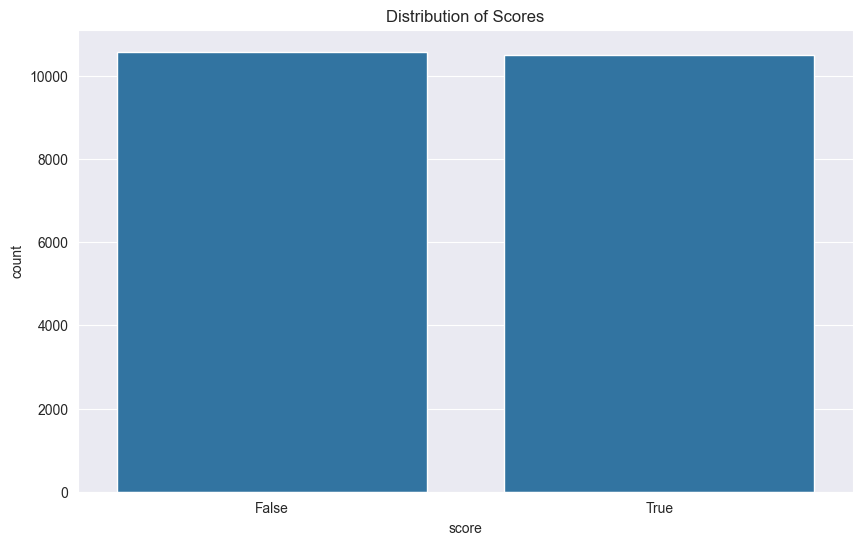

In [8]:
## 3. Data Distribution Analysis

# Distribution of scores
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df)
plt.title('Distribution of Scores')
plt.show()

**Conclusion** : The distribution of scores shows a balanced representation of correct (True) and incorrect (False) answers. This balance is favorable for our machine learning model, as it reduces the risk of bias towards one class and ensures that the model can learn effectively from both positive and negative examples.

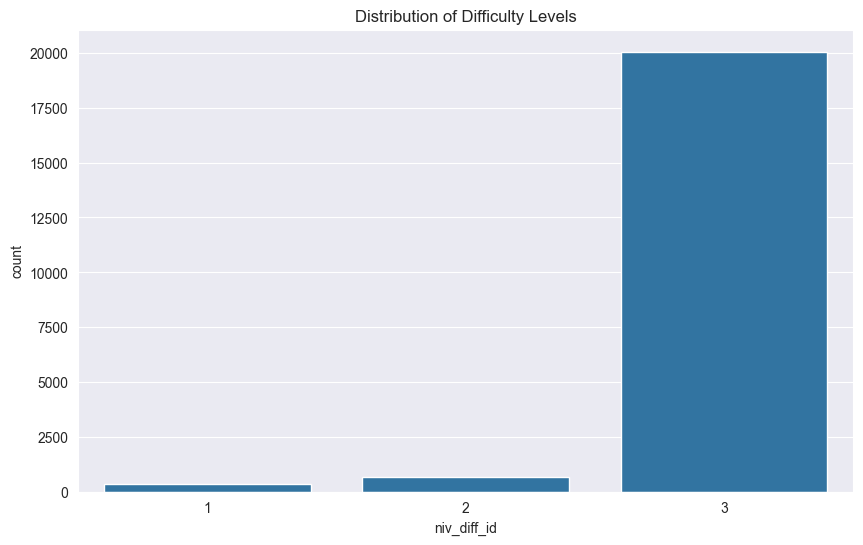

In [9]:
# Distribution of difficulty levels
plt.figure(figsize=(10, 6))
sns.countplot(x='niv_diff_id', data=df)
plt.title('Distribution of Difficulty Levels')
plt.show()

**Conclusion** : It's important to clarify the calculation of the difficulty score. The score takes into account various factors such as word frequency, echelon (educational level), number of syllables, grammatical category, etc. This comprehensive approach results in many words being classified as level 3 (the highest difficulty).

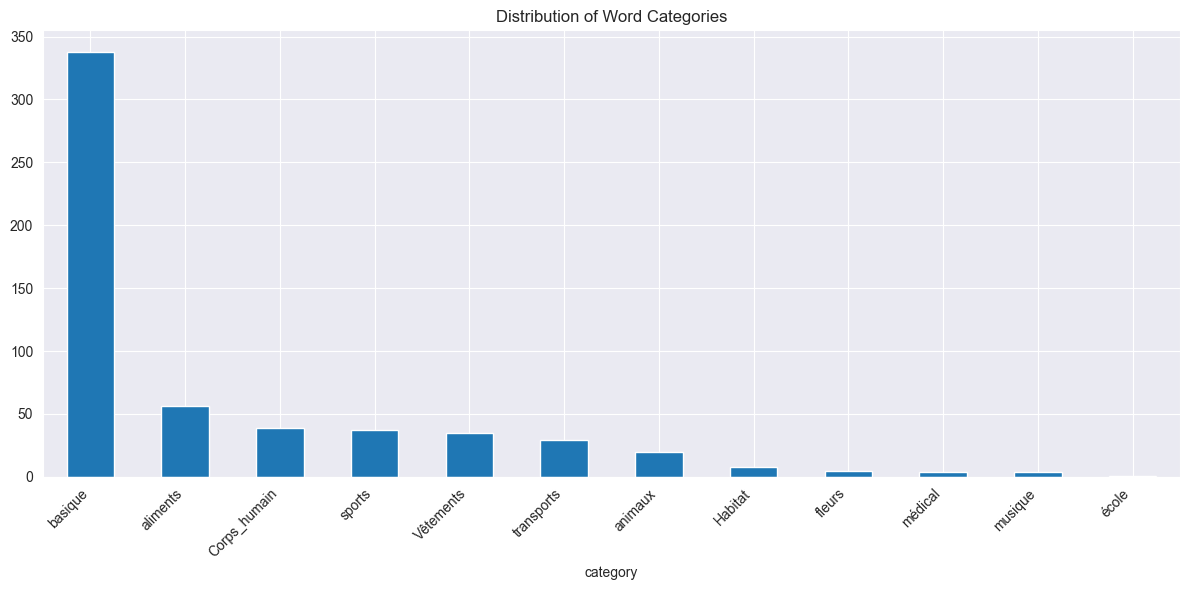

In [10]:
# Distribution of word categories
plt.figure(figsize=(12, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Word Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Conclusion** : The imbalance in word categories, with a higher proportion of "basique" (basic) words, is intentional and serves a purpose. These basic words act as an entry point for users, representing the most common and essential vocabulary.

## 4. User Behavior Analysis

# Average score by user

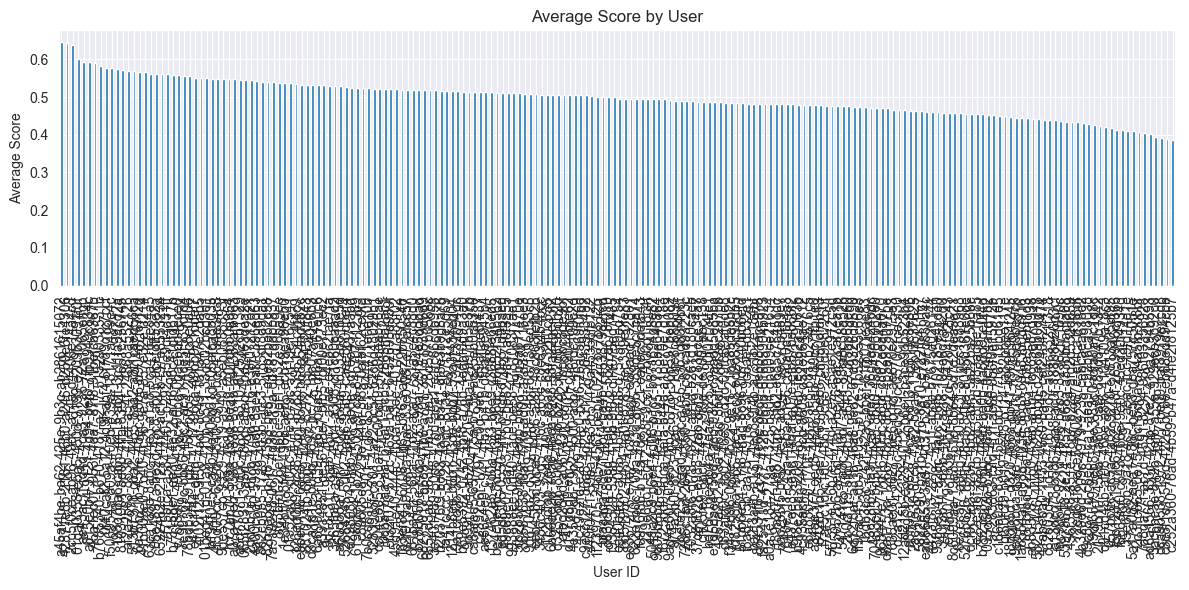

In [11]:
# Average score by user
user_avg_score = df.groupby('user_id')['score'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
user_avg_score.plot(kind='bar')
plt.title('Average Score by User')
plt.xlabel('User ID')
plt.ylabel('Average Score')
plt.tight_layout()
plt.show()

**Conclusion** : The 'Average Score by User' graph reveals a range of user performances. Most users achieve average scores between 0.4 and 0.6, indicating a moderate level of success across the user base. There are some high-performing users with scores above 0.6, while a smaller number of users show lower average scores below 0.4. This distribution suggests that the difficulty level of the quizzes is appropriate for the majority of users, providing a challenging yet achievable learning experience.
The data was generated with this in mind

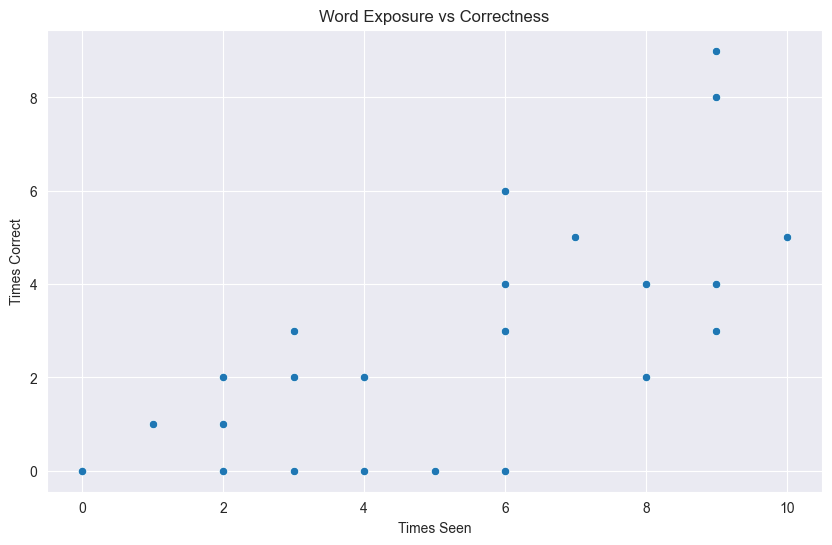

In [12]:
# Word exposure analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='times_seen', y='times_correct', data=df)
plt.title('Word Exposure vs Correctness')
plt.xlabel('Times Seen')
plt.ylabel('Times Correct')
plt.show()

This analysis examines the relationship between how often a word is seen (exposure) and how often it is correctly answered (correctness).

The scatter plot of 'Word Exposure vs Correctness' shows a general trend of increasing correctness as exposure increases. However, the relationship is not perfectly linear. We observe that words seen more frequently (higher 'Times Seen') tend to have a higher number of correct answers, but there's significant variation. This suggests that while repeated exposure generally improves performance, other factors like word difficulty or individual user characteristics also play a role in determining success rates.

## 5. Time-based Analysis

This graph shows user activity over time.


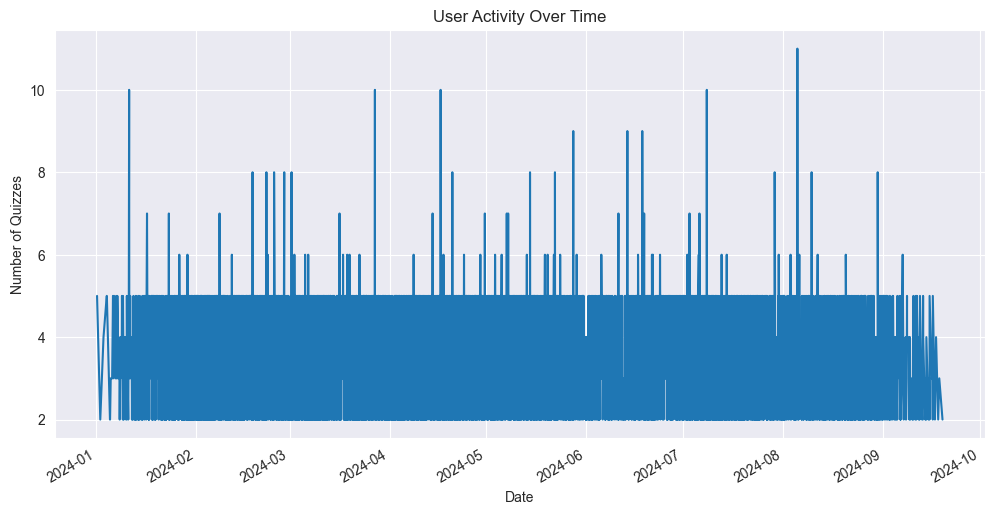

In [13]:
# Convert quiz_date to datetime if not already
df['quiz_date'] = pd.to_datetime(df['quiz_date'])

# User activity over time
user_activity = df.groupby('quiz_date').size()
plt.figure(figsize=(12, 6))
user_activity.plot()
plt.title('User Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Quizzes')
plt.show()

**Conclusion**: The 'User Activity Over Time' graph illustrates the engagement pattern of users from January to October 2024. We observe consistent daily activity, with most days showing between 2 to 6 quizzes taken. There are occasional spikes of higher activity, reaching up to 10 or 11 quizzes per day. This pattern suggests regular user engagement with periodic surges in activity, possibly due to factors like weekends, holidays, or specific learning initiatives.


C:\Users\33626\AppData\Local\Temp\ipykernel_34552\1509788984.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['quiz_month'] = df['quiz_date'].dt.to_period('M')


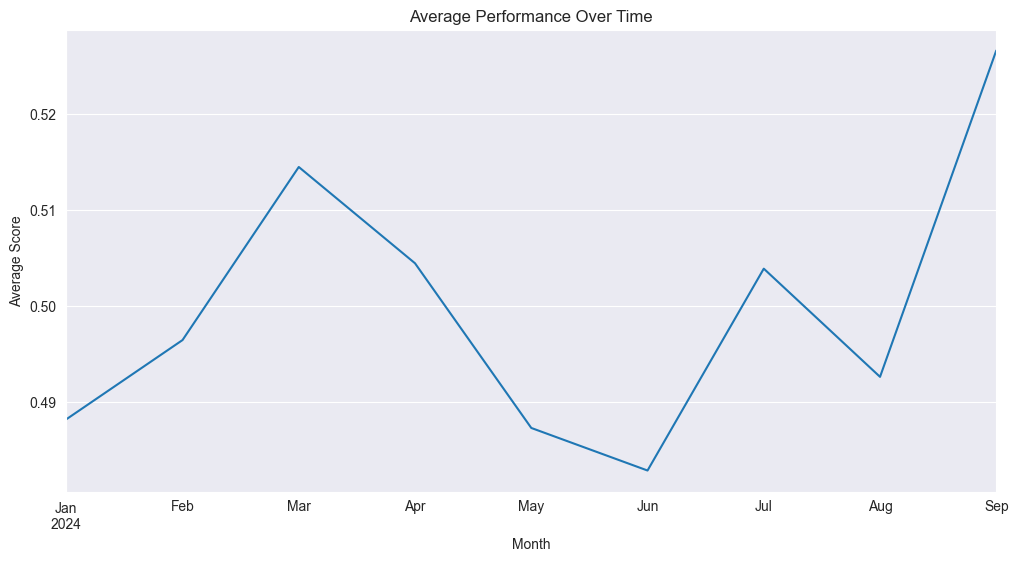

In [14]:
# Performance trend over time
df['quiz_month'] = df['quiz_date'].dt.to_period('M')
monthly_performance = df.groupby('quiz_month')['score'].mean()
plt.figure(figsize=(12, 6))
monthly_performance.plot()
plt.title('Average Performance Over Time')
plt.xlabel('Month')
plt.ylabel('Average Score')
plt.show()

**Conclusion** : The 'Average Performance Over Time' graph shows the monthly trend in user performance from January to September 2024. We observe fluctuations in average scores, with a general upward trend. The lowest point is in June, followed by a sharp increase to July and August, with September showing the highest average score. This overall positive trend suggests that users are improving over time, which is a good indicator of the effectiveness of the learning platform. The dips in certain months (like June) might warrant further investigation into potential seasonal effects or changes in content difficulty.

## 6. Word Difficulty Analysis

* Note: The 'frequence' column actually represents a calculated difficulty score.
* Higher values indicate more difficult words, not more frequent usage.

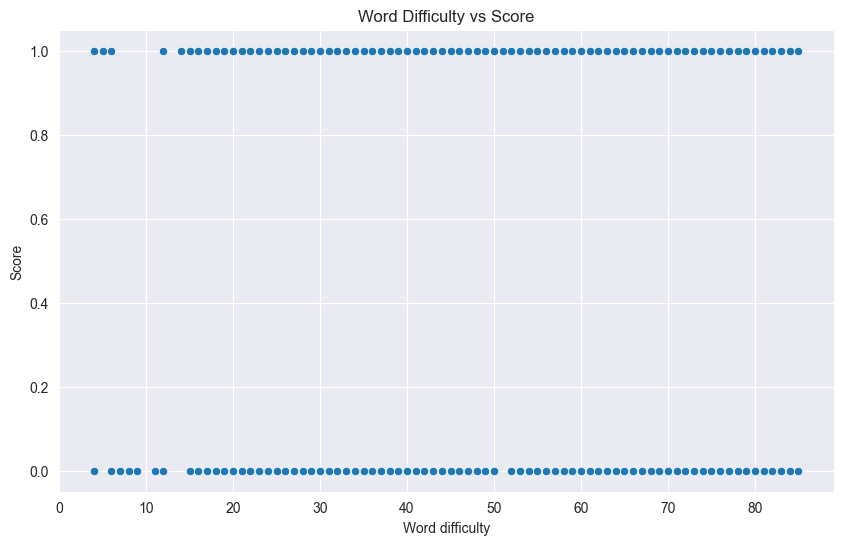

In [21]:
# Correlation between word frequency and score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequence', y='score', data=df)
plt.title('Word Difficulty vs Score')
plt.xlabel('Word difficulty')
plt.ylabel('Score')
plt.show()

**Conclusion** : The scatter plot of Word Difficulty Score vs User Score reveals an interesting pattern. There's a clear binary distribution of scores (0 or 1), representing incorrect or correct answers. Interestingly, there's no apparent linear relationship between the calculated difficulty score and user performance. This suggests that our current difficulty scoring system might not be a strong predictor of user success rates. Users seem capable of correctly answering words across the entire difficulty spectrum, indicating that other factors beyond our calculated difficulty score (such as individual user knowledge, learning context, or word familiarity) might play significant roles in determining success.

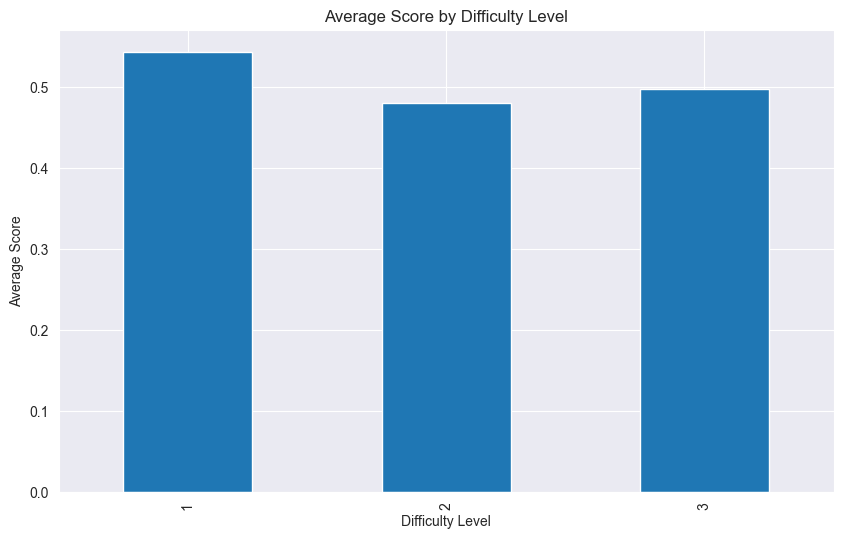

In [16]:
# Average score by difficulty level
avg_score_by_difficulty = df.groupby('niv_diff_id')['score'].mean()
plt.figure(figsize=(10, 6))
avg_score_by_difficulty.plot(kind='bar')
plt.title('Average Score by Difficulty Level')
plt.xlabel('Difficulty Level')
plt.ylabel('Average Score')
plt.show()

**Conclusion** : The bar chart displaying Average Score by Difficulty Level presents some counterintuitive results:

Level 1 (easiest): ~0.55 average score
Level 2: ~0.48 average score
Level 3 (hardest): ~0.50 average score

Surprisingly, the hardest level (3) shows a slightly higher average score than level 2. This unexpected outcome could suggest several things:

Our difficulty level assignment might need recalibration, as it doesn't align with actual user performance.
Users might be more focused or motivated when facing words they perceive as more challenging.
There could be an imbalance in the number of attempts or the types of words presented at each difficulty level.
This insight calls for a deeper investigation into our difficulty classification method and how users interact with words of varying difficulty.

## 7. Correlation Analysis

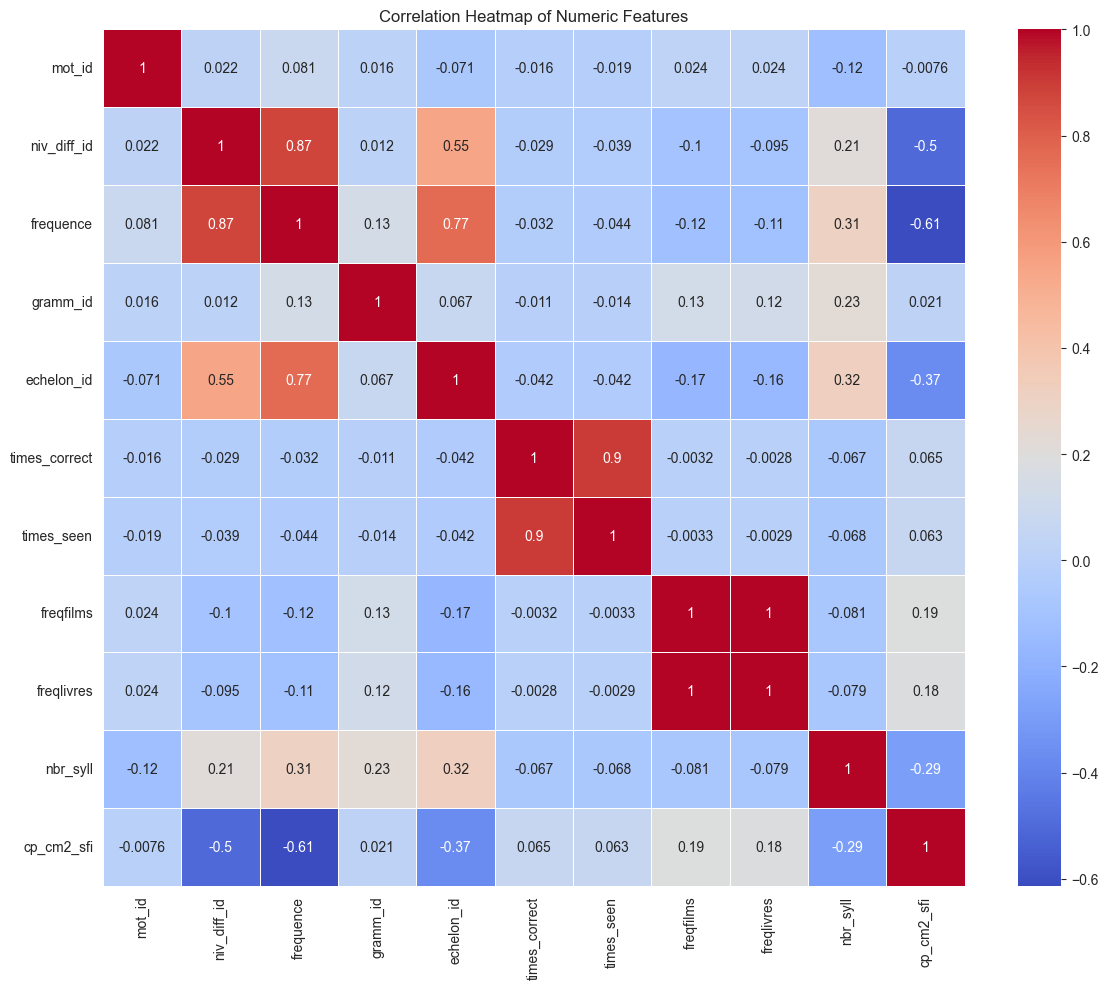

In [18]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

**Conclusion** : The correlation heatmap reveals several important relationships:

There's a strong positive correlation (0.87) between 'niv_diff_id' (difficulty level) and 'frequence' (our calculated difficulty score). This high correlation suggests that our difficulty scoring system aligns well with the assigned difficulty levels.
'Echelon_id' shows a strong correlation (0.77) with 'frequence', indicating that our difficulty score increases with educational level, as expected.
'Times_correct' and 'times_seen' have a near-perfect correlation (0.9), which is logical as users are more likely to answer correctly the more they encounter a word.
Interestingly, 'cp_cm2_sfi' (a specific difficulty metric) has a strong negative correlation (-0.61) with 'frequence'. This suggests that words with higher difficulty scores tend to have lower 'cp_cm2_sfi' values, which might indicate a discrepancy in how these two metrics assess word difficulty.
'Freqfilms' and 'freqlivres' show a perfect correlation, suggesting redundancy in these features.

These correlations provide valuable insights into the relationships between our difficulty metrics and other word characteristics, highlighting areas where our difficulty assessment might be refined or where certain features might be combined or eliminated to reduce redundancy

## 8. Key Insights and Next Steps

Key Insights:
1. Score Distribution: Scores are binary (0 or 1), with no clear linear relationship to word frequency.
2. User Behavior Patterns: Users show consistent engagement with periodic spikes in activity, suggesting regular learning habits with occasional intensive sessions.
3. Word Difficulty and Performance: Counterintuitively, the hardest difficulty level shows slightly better performance than medium difficulty, indicating potential issues with difficulty scaling or user approach to challenging words.
4. Time-based Trends: User performance generally improves over time, with some monthly fluctuations, suggesting overall effective learning but potential seasonal effects.
5. Feature Correlations: Strong correlations exist between certain features (e.g., times_seen and times_correct, difficulty level and word frequency), which can inform feature selection and engineering.

Next Steps:
1. Feature Engineering: 
   - Create composite features combining correlated variables (e.g., difficulty and frequency).
   - Develop time-based features to capture learning progression.
   - Investigate the cp_cm2_sfi score as a potential key feature due to its negative correlation with frequency.

2. User Segmentation: 
   - Group users based on performance trends and activity levels.
   - Analyze how different user segments interact with words of varying difficulty.

3. Word Embedding: 
   - Utilize the word embedding features (PCA components) to explore semantic relationships between words and their impact on learning outcomes.

4. Time Series Analysis: 
   - Conduct a deeper dive into temporal patterns of user learning.
   - Investigate potential seasonality in user performance and engagement.

5. Model Development: 
   - Use insights to inform initial model design, particularly focusing on the non-linear relationship between word attributes and success rates.
   - Consider ensemble methods or multi-model approaches to capture different aspects of user-word interactions.

6. Difficulty Scaling Review:
   - Reassess the current difficulty scaling system, particularly the distinction between levels 2 and 3.
   - Consider creating a more granular or dynamic difficulty scale based on user performance data.

7. Feature Selection:
   - Evaluate the importance of freqfilms and freqlivres separately, given their perfect correlation.
   - Focus on features with strong correlations to the target variable (score) for initial modeling.

8. User Experience Analysis:
   - Investigate why users perform better on the hardest words - is it due to increased focus, better learning materials, or other factors?

9. Data Quality Check:
   - Verify the accuracy of difficulty assignments, especially for level 2 and 3 words.
   - Ensure that the word frequency data is representative and up-to-date.

10. Adaptive Learning Algorithm:
    - Develop an algorithm that adjusts word presentation based on user performance trends and the insights gained from this analysis.

In [19]:
# Close the database connection
conn.close()

## Conclusion and Insights

These insights provide valuable direction for feature engineering and model development. However, it's crucial to remember that these patterns are based on synthetic data and may not fully represent real-world user behaviors. As we move forward with model development, we should:

1. Refine our difficulty scoring system to better predict user performance.
2. Investigate the factors contributing to better performance on the hardest difficulty level.
3. Consider creating composite features that combine correlated variables.
4. Develop time-based features to capture learning progression.
5. Prepare for potential adjustments when transitioning to real user data.
